In [23]:
import cuqi
import numpy as np
import matplotlib.pyplot as plt
import deepinv as dinv
import torch
from deepinv.utils.demo import load_url_image
import scipy

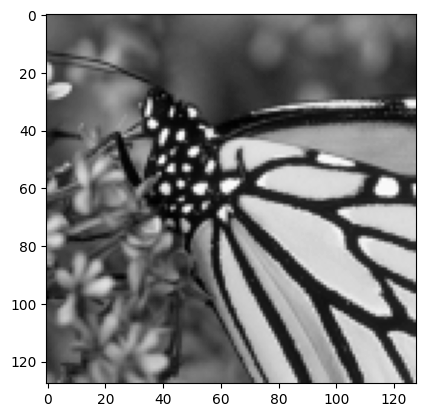

In [ ]:
import skimage as ski
from skimage.transform import rescale, resize, downscale_local_mean
image = resize(ski.util.img_as_float(ski.io.imread("05.png")), (128,128))
x_true = image.flatten()
dim = image.shape[0]
plt.imshow(image, cmap="gray")

In [ ]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


True image shape: (16384,)


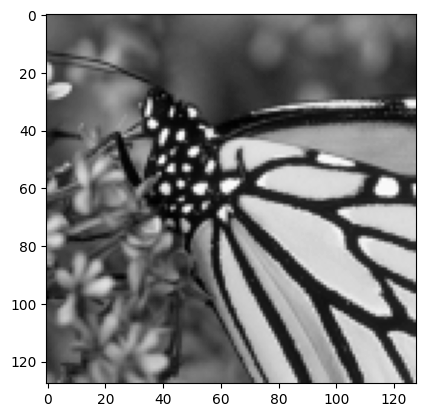

In [29]:
plt.imshow(x_true.reshape(dim,dim), cmap="gray")
print("True image shape:", x_true.shape)

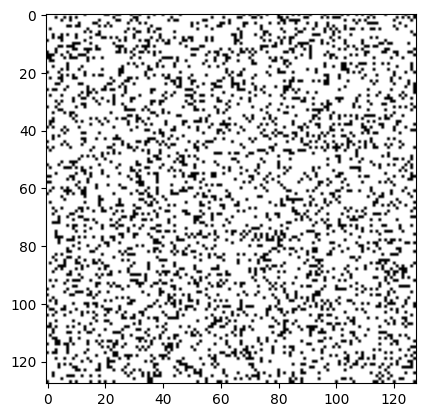

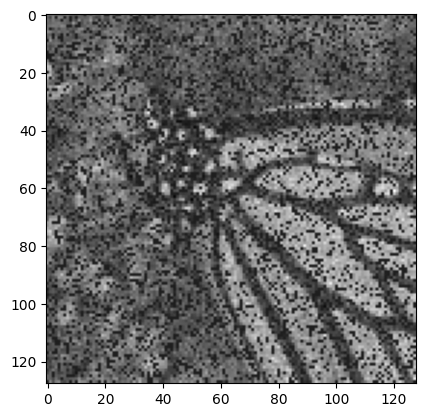

In [31]:
# define forward operator and create data
np.random.seed(1)
# 1. manual mask
zero_density = 0.8#0.8#0.7   # we keep 70% of the pixels
mask_vector = np.random.random(size=dim**2) < zero_density
# convert mask_vector to a vector of 0s and 1s
mask_vector = mask_vector.astype(int)
# mask = np.diag(mask_vector)
mask = scipy.sparse.diags(mask_vector)
# # 2. mask imported from deepinv
# mask_vector = np.load("mask.npy")  # load a pre-defined mask
# mask_vector = mask_vector.flatten()
# mask = np.diag(mask_vector)
y_exact = x_true @ mask

noise_std = 0.1 # half noise
# 1. manual noise
y_obs = y_exact + np.random.normal(0, noise_std, size=y_exact.shape)@mask
# # 2. imported y_obs
# y_obs = np.load("y_obs.npy").flatten()  # load a pre-defined observation

plt.imshow(mask_vector.reshape(dim, dim), cmap='gray')
plt.figure()
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')

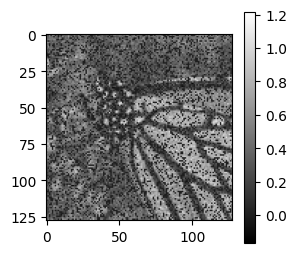

In [32]:
plt.figure(figsize=(3, 3))
plt.imshow(y_obs.reshape(dim, dim), cmap='gray')
plt.colorbar()

In [33]:
# tweak denoiser
sigma_denoiser = 2 / 255
sigma_denoiser =sigma_denoiser
denoiser=dinv.models.DnCNN(pretrained="download_lipschitz", in_channels=1, out_channels=1)

In [34]:
def nn_denoiser(x, restoration_strength=None):
    with torch.no_grad():
        result = denoiser.forward(torch.tensor(x.reshape(1,1,dim,dim), dtype=torch.float32), sigma=sigma_denoiser).detach().reshape(dim*dim).numpy()
    return result, None

In [35]:
restorator=cuqi.implicitprior.RestorationPrior(
    nn_denoiser,
    restorator_kwargs={},
    geometry=cuqi.geometry.Image2D((dim, dim), visual_only=True),
)

In [36]:
myprior = cuqi.implicitprior.MoreauYoshidaPrior(restorator, sigma_denoiser**2)

In [ ]:
# forward, likelihood
forward = cuqi.model.LinearModel(mask, domain_geometry=restorator.geometry, range_geometry=restorator.geometry)

prec = scipy.sparse.diags(np.ones(dim**2) / noise_std**2)  # sparse diagonal matrix
y = cuqi.distribution.Gaussian(forward@myprior, prec=prec)

In [44]:
# post = cuqi.distribution.JointDistribution(restorator, y)(y=y_obs)
post = cuqi.distribution.JointDistribution(myprior, y)(y=y_obs)
step_size = 0.1*0.01 * (noise_std**2) * 2 # 2.5e-05 # is multiplied by 2 so be the same scaling as in deepinv ## note it is scaled by 0.1 now compared to deepinv
# x_initial = np.load("x_inital.npy").flatten()  # load a pre-defined initial guess
x_initial = y_obs.copy()
# sampler = cuqi.experimental.mcmc.PnPULA(post, scale=step_size, smoothing_strength=sigma_denoiser, initial_point=x_initial)
sampler = cuqi.experimental.mcmc.ULA(post, scale=step_size, initial_point=x_initial)
sampling_steps = 60000
warmup_steps = 40000
np.random.seed(0)  # for reproducibility
sampler.warmup(warmup_steps)
sampler.sample(sampling_steps)

Sample: 100%|██████████| 60000/60000 [1:24:52<00:00, 11.78it/s, acc rate: 100.00%]


Sampler: ULA 
 Target: 
 	 Posterior(
    Equation:
	 p(myprior|y) ∝ L(myprior|y)p(myprior)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['myprior'].
 	myprior ~ CUQI MoreauYoshidaPrior.
 ) 
 Current state: 
	 current_point: [0.40695057 0.41925335 0.41985794 ... 0.27816771 0.36268532 0.61737861] 
	 current_target_grad: [ 56.96505944 -64.48457586 -52.99792777 ...  57.61630289 -28.37349075
  12.9894088 ] 
	 scale: 2.0000000000000005e-05 

In [45]:
# samples = sampler.get_samples()
thinning = 10  # thinning factor
samples = sampler.get_samples().burnthin(warmup_steps, thinning)

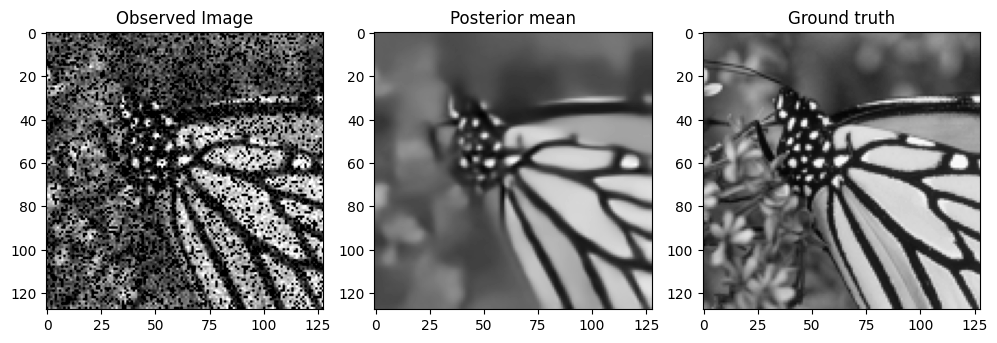

In [49]:
vmin = 0.1#-0.1
vmax = 0.9#1.1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(y_obs.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax1.set_title('Observed Image')
ax2.imshow(samples.mean().reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax2.set_title('Posterior mean')
ax3.imshow(x_true.reshape(dim, dim), cmap='gray', vmin=vmin, vmax=vmax)
ax3.set_title('Ground truth')
plt.tight_layout()
plt.savefig("comparision.pdf")

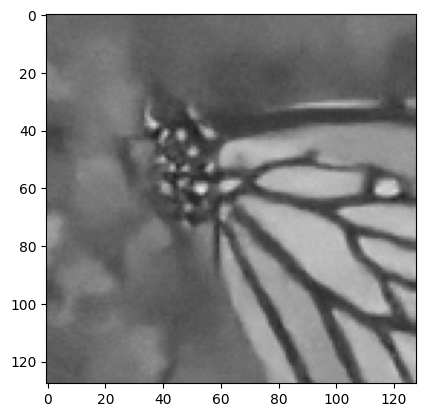

In [ ]:
samples.plot(-1, vmin=vmin, vmax=vmax)

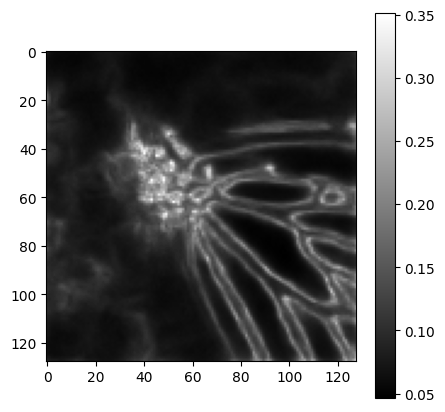

In [52]:
samples.plot_ci_width(cmap='gray')
# get fig of the last plot
plt.gcf().set_size_inches(5,5)
plt.title("")
plt.colorbar()
plt.savefig("ci_width.pdf")

Selecting 5 randomly chosen variables


array([[<Axes: title={'center': 'v1224'}>,
        <Axes: title={'center': 'v1224'}>],
       [<Axes: title={'center': 'v3090'}>,
        <Axes: title={'center': 'v3090'}>],
       [<Axes: title={'center': 'v5060'}>,
        <Axes: title={'center': 'v5060'}>],
       [<Axes: title={'center': 'v13432'}>,
        <Axes: title={'center': 'v13432'}>],
       [<Axes: title={'center': 'v14919'}>,
        <Axes: title={'center': 'v14919'}>]], dtype=object)

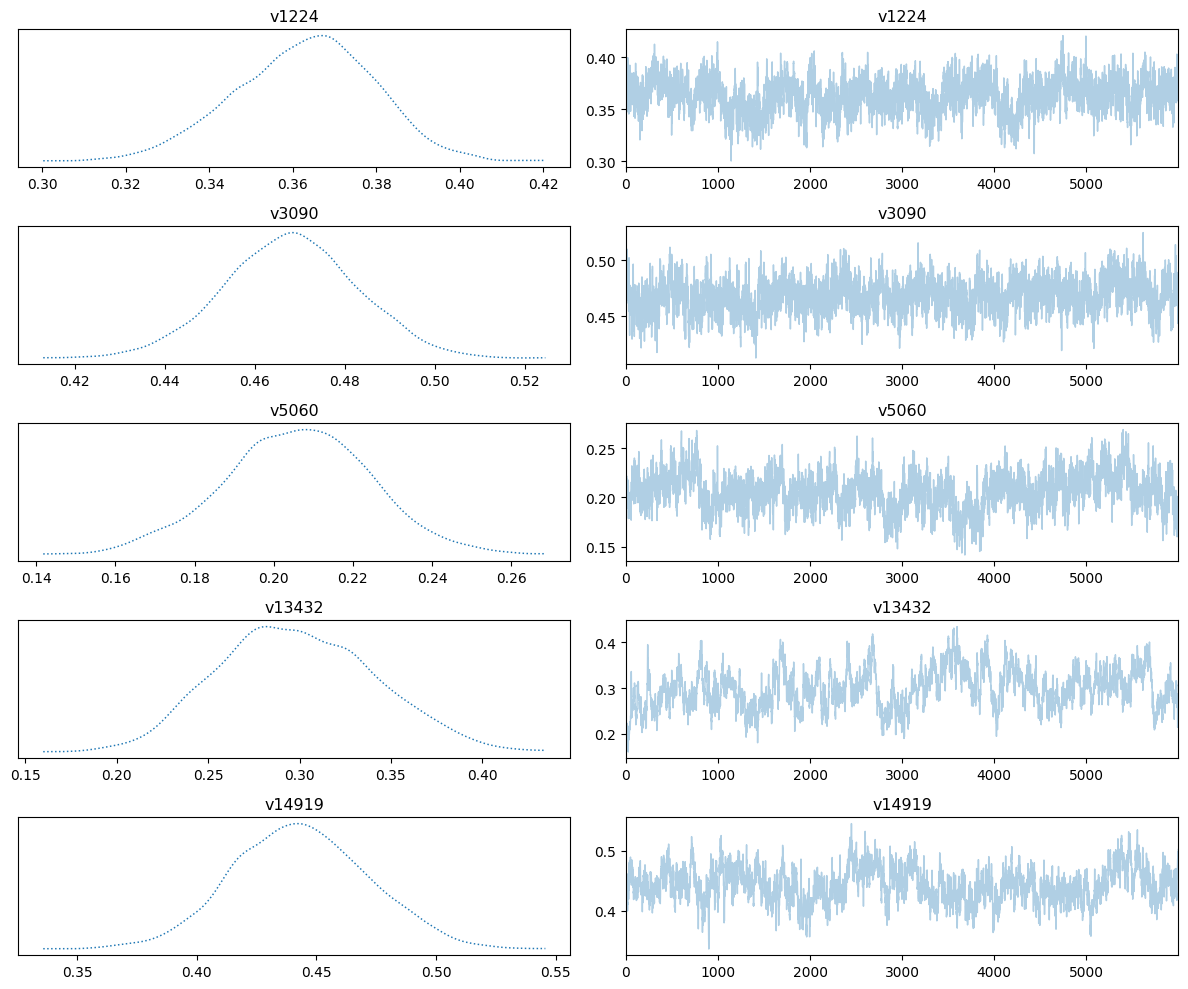

: 

In [ ]:
samples.plot_trace()

In [ ]:
np.save("butterfly_samples.npy", samples)